In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from tqdm import tqdm
import json
import os
import random
import math
import pickle
#import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix
from collections import deque

# import stellargraph as sg
# from stellargraph.mapper import FullBatchNodeGenerator
# from stellargraph.layer import GCN
import networkx as nx
import warnings
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense, Embedding,LeakyReLU, Maximum
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
# from stellargraph import StellarGraph
# from stellargraph.layer.gcn import GatherIndices
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

%matplotlib inline

In [3]:
dataFrame = pd.read_csv("/content/drive/MyDrive/GCN Classification/citation_sentiment_corpus.txt", sep = "	", header = None)
dataFrame.columns = ["Source_PaperID", "Target_PaperID", "Sentiment", "Citation_text"]
dataFrame.Sentiment = dataFrame.Sentiment.replace({"o": 1,"p": 2,"n": 0})

In [4]:
Source = dataFrame['Source_PaperID']
Target = dataFrame['Target_PaperID']
Sentiment = dataFrame['Sentiment']
G = nx.DiGraph(directed=True)
edges = pd.DataFrame(
    {
        "source": Source,
        "target": Target,
        "weight": Sentiment
    }
)
G = nx.from_pandas_edgelist(edges, edge_attr=True,create_using=nx.DiGraph())

In [5]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='Citations')
citation_counts = s.to_frame().sort_values('Citations', ascending=False)
citation_counts.value_counts()

Citations
1            1785
2             703
3             295
4             121
0              77
5              59
6              19
7               7
8               3
dtype: int64

In [6]:
citation_counts = citation_counts.reset_index(level=0)
citation_counts.columns = ['Node', 'Citations']
citation_counts.head()

,Node,Citations
0,W08-0306,8
1,N09-1058,8
2,D07-1070,8
3,N09-1049,7
4,P08-1068,7


In [7]:
zero_list = []
for i,j in zip(citation_counts['Node'], citation_counts['Citations']):
    if(j == 0):
      
        zero_list.append(i)
G.remove_nodes_from(zero_list)

In [8]:
print("Number of Nodes: ",G.number_of_nodes())
print("Number of Edges: ",G.number_of_edges())

Number of Nodes:  2992
Number of Edges:  1589


In [128]:
import os
all_data = []

for root,dirs,files in os.walk('.'):
    for file in files:
        if 'node2vec_embeddings.txt' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
all_data

#parse the data
nodes = []
node2vec_cc = []

for i,data in enumerate(all_data):
    elements = data.split(' ')
    node2vec_cc.append(elements[1:])
    nodes.append(elements[0])

In [129]:
node2vec_cc.pop(0)
nodes.pop(0)

'2992'

In [130]:
! pip install tensorflow_text
! pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import tensorflow_hub as hub
import tensorflow_text as text

In [132]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2"
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [133]:
df = dataFrame

In [134]:
citation_text = []
for i in nodes:
    for j,k in zip(df['Source_PaperID'],df['Citation_text']):
        if(i==j):
            citation_text.append(k)
            break

In [135]:
text_test = citation_text
text_preprocessed = bert_preprocess_model(text_test)


In [136]:
bert_model = hub.KerasLayer(encoder_url)
bert_results = bert_model(text_preprocessed)
bert_results.keys()

dict_keys(['default', 'pooled_output', 'sequence_output', 'encoder_outputs'])

In [137]:
pooled_output = bert_results['pooled_output']
print("Shape of pooled_output:", pooled_output.shape)
print("Values of pooled_output:", pooled_output.numpy())

Shape of pooled_output: (2992, 128)
Values of pooled_output: [[-0.14681141  0.8611589  -0.06422304 ...  0.923064    0.31110084
   0.94732934]
 [ 0.01465445  0.96255964  0.45316988 ...  0.949046    0.9329498
   0.9408248 ]
 [ 0.05313522  0.61497766  0.41243902 ...  0.95162016  0.8346753
   0.9756313 ]
 ...
 [-0.06295735  0.9119968  -0.23528008 ...  0.9131104   0.29114988
   0.97878695]
 [-0.03002188  0.85984194 -0.19387652 ...  0.9201683   0.4242918
   0.974417  ]
 [-0.01677701  0.92273664  0.74263084 ...  0.9372823   0.8992512
   0.90070945]]


,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.07687346,-0.9226167,0.78992116,-0.84812886,0.49845138,0.38957667,-0.3366734,0.14115053,0,1
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,-0.088856906,-0.49268368,1.0905964,-0.65956247,-0.5185808,-0.29776338,-0.80166334,-0.30129644,1,1
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,-0.6869531,0.84110194,0.27185586,0.67025656,-0.4129803,0.6605675,0.44515988,0.49230257,2,1
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,-0.82656157,-0.0026124702,0.40108162,0.9708959,-0.65667415,-1.4535186,-0.87660235,-0.3967433,3,1
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,-0.3201643,0.39295188,-0.2822794,0.3054697,-0.4024803,-0.9890051,-1.0255593,-0.8270502,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,-0.0010220176,0.0018005054,0.0034822198,0.0030971896,0.0043546455,-0.0037902752,-0.0029614503,0.0018936889,-0.007540119,-0.003903429,...,-0.005177743,-0.0072172927,0.0027994448,0.0013730638,-0.0074134255,3.5839155e-05,-0.0008219704,0.0076927505,2987,1
2988,0.0051305247,-0.00020716991,0.0056356033,-0.001965833,-0.005993656,0.0070756795,-0.0033855522,0.0054469733,0.006430502,-0.00091289077,...,0.0061046714,-0.0038707256,-0.0009500375,0.005390168,0.004127724,0.005776765,-0.0035727564,-0.005217186,2988,2
2989,-0.0021094028,-0.0057895826,-0.0016520573,0.0016188109,0.0019293511,0.0026742155,-0.0032843538,-0.0041193217,-0.0070835156,-0.006367827,...,0.007336351,0.0021708645,0.0049110325,-0.0013499325,0.0031697582,-0.007376888,-0.007607705,0.0018382426,2989,1
2990,-0.0029256037,-0.0078072418,-0.0019403696,0.0041975277,0.006259068,0.0061134314,-0.00096577685,0.0055725453,0.0049415994,-0.0049427627,...,0.0018232781,-0.003252781,0.0038279882,-0.004984987,-0.007729613,0.006608147,0.005017368,-0.00040707085,2990,1


In [138]:
final_embeddings = np.concatenate((node2vec_cc, pooled_output), axis=1)
print(final_embeddings.shape)

(2992, 256)


In [139]:
column_names =[f"term_{idx}" for idx in range(256)]
final_embeddings = pd.DataFrame(final_embeddings, columns = column_names)

In [140]:
final_embeddings.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_246,term_247,term_248,term_249,term_250,term_251,term_252,term_253,term_254,term_255
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.09419684,0.21723117,-0.65625465,-0.8931912,0.99321574,-0.0627431,0.9993638,0.923064,0.31110084,0.94732934
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,-0.10059645,0.88226485,-0.14997397,-0.9795217,0.9907901,-0.036346678,0.9998766,0.949046,0.9329498,0.9408248
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,-0.10665014,0.3411893,-0.8848918,-0.99199384,0.941894,-0.016466457,0.99100703,0.95162016,0.8346753,0.9756313
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,-0.08894623,0.8286917,-0.571684,-0.9948903,0.96066123,-0.07018457,0.99682266,0.9499179,0.36198604,0.9919779
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,-0.06531135,0.80386055,-0.37320158,-0.9897013,0.9763744,-0.026971642,0.99970084,0.9178072,0.95420295,0.9170983


In [141]:
final_embeddings["Node_id"] = nodes

In [142]:
df = dataFrame
labels = []
for i in nodes:
    for j,k in zip(df['Source_PaperID'],df['Sentiment']):
        if(i==j):
            labels.append(k)
            break

In [143]:
final_embeddings["label"] = labels

In [144]:
dataset = final_embeddings

In [145]:
dataset.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_248,term_249,term_250,term_251,term_252,term_253,term_254,term_255,Node_id,label
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.65625465,-0.8931912,0.99321574,-0.0627431,0.9993638,0.923064,0.31110084,0.94732934,J97-3002,1
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,-0.14997397,-0.9795217,0.9907901,-0.036346678,0.9998766,0.949046,0.9329498,0.9408248,N03-1017,1
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,-0.8848918,-0.99199384,0.941894,-0.016466457,0.99100703,0.95162016,0.8346753,0.9756313,W96-0213,1
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,-0.571684,-0.9948903,0.96066123,-0.07018457,0.99682266,0.9499179,0.36198604,0.9919779,W02-1011,1
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,-0.37320158,-0.9897013,0.9763744,-0.026971642,0.99970084,0.9178072,0.95420295,0.9170983,P04-1035,1


In [ ]:
# N = dataset['embeddings'].shape[0] #the number of nodes
# F = dataset['embeddings'].shape[1] #the size of node features
# print('X shape: ', node2vec_cc.shape)


# print('\nNumber of nodes (N): ', N)
# print('\nNumber of features (F) of each node: ', F)
# print('\nCategories: ', set(labels))

# num_classes = len(set(labels))
# print('\nNumber of classes: ', num_classes)
# A = nx.adjacency_matrix(G)
# print('Graph info: ', nx.info(G))

In [146]:
node2vec_cc = dataset

In [147]:
graph = nx.to_pandas_edgelist(G)

graph

,source,target,weight
0,W09-0604,N03-1003,1
1,A00-1031,W96-0213,1
2,A97-1004,W96-0213,1
3,C08-1026,P08-1085,2
4,N01-1023,W96-0213,1
...,...,...,...
1584,W07-1209,W96-0213,1
1585,W07-1516,W96-0213,2
1586,W07-2053,W96-0213,1
1587,W08-0611,W96-0213,1


In [21]:
node2vec_cc["Node_id"] = dataset["Node_id"]
node2vec_cc["label"] = dataset["label"]

In [148]:
paper_idx = {name: idx for idx, name in enumerate(node2vec_cc["Node_id"])}

node2vec_cc["Node_id"] = node2vec_cc["Node_id"].apply(lambda name: paper_idx[name])
graph["source"] = graph["source"].apply(lambda name: paper_idx[name])
graph["target"] = graph["target"].apply(lambda name: paper_idx[name])

In [149]:
train_label_cc, test_pages = train_test_split(node2vec_cc['label'], test_size = 0.30)
val_label_cc, test_label_cc = train_test_split(test_pages, test_size=0.40)

In [150]:
train_Node2Vec_cc = node2vec_cc.loc[train_label_cc.index]
val_Node2Vec_cc = node2vec_cc.loc[val_label_cc.index]
test_Node2Vec_cc = node2vec_cc.loc[test_label_cc.index]

In [151]:
train_Node2Vec_cc.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_248,term_249,term_250,term_251,term_252,term_253,term_254,term_255,Node_id,label
1171,0.003904257,0.00026926026,0.00578364,0.004605271,0.002986637,-0.0052307276,-0.00748899,0.005986546,-0.0036963122,0.0049456116,...,-0.8330212,-0.9375283,0.99304277,-0.04454432,0.999083,0.93565273,0.15030472,0.9588355,1171,1
2017,-0.0019702977,-0.0073526585,0.0019434486,0.0044168076,-0.00028037,-0.0017946865,-0.0025638184,0.0066007692,-0.0027221842,0.0072103525,...,-0.14775258,-0.987253,0.9597354,0.0072917594,0.9951499,0.9360734,0.7365293,0.9750155,2017,1
541,-0.0046473136,0.003318864,-0.003835124,0.0011053178,-0.007212081,-0.0013620462,-0.0009688055,0.004573956,0.00030231662,0.00035468768,...,-0.0047327965,-0.9056447,0.9964646,0.006462078,0.9997575,0.91362435,0.15081376,0.95870787,541,1
2413,0.03921514,-0.12318319,0.19756174,0.08133884,0.23847754,-0.47568318,-0.14142884,-0.21487013,0.22995964,-0.08593321,...,-0.7927224,-0.97119904,0.9958587,-0.081537284,0.99990183,0.85987717,0.9041388,0.9892507,2413,1
635,0.087772,-0.33030838,0.30359414,0.039161038,-0.19085069,-0.44254395,0.17806913,0.324556,-0.047469184,-0.052392606,...,-0.8233291,-0.986967,0.99266845,-0.012198962,0.99933857,0.9366264,0.832237,0.9801242,635,1


In [152]:
train_Node2Vec_cc.shape, val_Node2Vec_cc.shape, test_Node2Vec_cc.shape

((2094, 258), (538, 258), (360, 258))

In [153]:
test_Node2Vec_cc

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_248,term_249,term_250,term_251,term_252,term_253,term_254,term_255,Node_id,label
1822,-0.22081286,-0.4513078,0.23812294,0.0541671,-0.05226493,-0.26636297,0.0129806055,0.10570946,-0.0850539,-0.08697516,...,-0.744029,-0.99247354,0.95744514,0.02219663,0.9986061,0.9667852,0.88802886,0.98257,1822,1
260,0.028821964,-0.280938,0.31509706,-0.025538879,0.14602588,-0.22544502,0.1256328,-0.015987922,-0.04146086,-0.14497083,...,-0.84940773,-0.9887898,0.9865577,-0.02719791,0.99615103,0.9500899,0.5049467,0.99295634,260,1
2623,0.0016288403,-0.0040996308,-0.00027186517,-0.0072162123,-0.0016213851,0.0070674084,-0.0035875589,-0.0005018972,0.004142748,0.0047815368,...,-0.45865497,-0.974274,0.9672708,-0.024190769,0.99722266,0.8477422,0.8068332,0.9515538,2623,1
470,0.0016207471,0.0022703977,0.005506522,-0.0065585114,-0.0010111546,0.0073622456,0.0029372983,-0.003015614,-0.0053779194,0.0055445395,...,-0.2785579,-0.9874684,0.99673206,-0.03488571,0.999951,0.94243586,0.37354076,0.9790787,470,1
2236,-0.006789916,-0.0037123244,0.0036245724,0.0075233895,-0.006645824,0.006998798,-0.0067669507,-0.0040716464,0.00095539726,8.889567e-05,...,-0.13846509,-0.99008447,0.98061615,0.0016256192,0.9998821,0.9752973,0.8583495,0.93313855,2236,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0022512097,-0.001956895,0.0039276667,-0.0056352923,-0.002884074,-0.0067672664,0.00087447837,0.006554746,0.0010802019,-0.0028743306,...,-0.853877,-0.9646136,0.9863451,-0.07286784,0.99867207,0.9126002,0.91566026,0.9920171,595,1
2056,0.00010913797,0.007163032,0.0036809836,0.0077501554,-0.0012624012,0.0006709248,-0.0031540291,0.0075329766,-0.00606927,0.0003568018,...,-0.7985491,-0.97228533,0.9971333,0.013905828,0.99990135,0.9277454,0.8502513,0.9852176,2056,1
1698,0.0017163334,0.0066827564,-0.0011059055,-0.0061798766,-0.0074785743,0.0066759484,-0.002832923,0.0077231154,0.004858015,-0.0062389215,...,-0.68386096,-0.9938918,0.9946017,-0.051291265,0.9989482,0.9397549,0.86990285,0.9963885,1698,1
1274,0.0074990047,-0.005617867,0.0039500017,0.0008526789,0.00038802996,-0.00025033392,-0.0064448286,0.003289991,-0.0057755103,0.006523907,...,-0.86898255,-0.98933977,0.9909639,-0.025657091,0.9999471,0.9010722,0.6540526,0.98569494,1274,1


In [154]:
y_train = np.array(list(train_label_cc.values))
y_val = np.array(list(val_label_cc.values))
y_test = np.array(list(test_label_cc.values))

In [155]:
y_train

array([1, 1, 1, ..., 1, 2, 1])

In [156]:
graph.head()

,source,target,weight
0,2043,6,1
1,665,2,1
2,2769,2,1
3,2390,58,2
4,2659,2,1


In [157]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = graph[["source", "target"]].to_numpy().T

# Create an edge weights array of ones.
# edge_weights =tf.cast(graph_cc['combined_score'].to_numpy(),dtype = tf.dtypes.float32) 

edge_weights = tf.ones(shape=edges.shape[1],dtype = tf.dtypes.float32)
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    node2vec_cc.sort_values('Node_id')[column_names].apply(pd.to_numeric).to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 1589)
Nodes shape: (2992, 256)


In [158]:
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
kernel_regularizer='l2'

hidden_units = [256,128]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 100
batch_size = 256
bias_regularizer = "l2"

In [159]:
import numpy as np
import datetime

def accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true), ', set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def precision(y_true, y_pred, normalize=True, sample_weight=None):
    pre_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_prec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_prec = 1
            pre_list.append(tmp_prec)
        elif len(set_pred) > 0:
            tmp_prec = len(set_true.intersection(set_pred))/\
                    float(len(set_pred))
            pre_list.append(tmp_prec)
        else:
            None
    return np.mean(pre_list)

# def recall(y_true, y_pred, normalize=True, sample_weight=None):
#     rec_list = []
#     for i in range(y_true.shape[0]):
#         set_true = set( np.where(y_true[i])[0] )
#         set_pred = set( np.where(y_pred[i])[0] )
#         tmp_rec = None
#         if len(set_true) == 0 and len(set_pred) == 0:
#             tmp_rec = 1
#         else:
#             tmp_rec = len(set_true.intersection(set_pred))/\
#                     float(len(set_true))
#         rec_list.append(tmp_rec)
#     return np.mean(rec_list)

def recall(y_true, y_pred, normalize=True, sample_weight=None):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    rec_list = []
    
    for i in range(possible_positives.shape[0]):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i] >= 0.5)[0])
        
        if len(set_true) == 0:
            tmp_rec = 0
        else:
            tmp_rec = len(set_true.intersection(set_pred))/float(len(set_true))
        
        rec_list.append(tmp_rec)
    
    if normalize:
        return np.mean(rec_list)
    else:
        return np.sum(true_positives) / (np.sum(possible_positives) + K.epsilon())


def f_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = (2*len(set_true.intersection(set_pred)))/\
                    float( len(set_true) + len(set_pred))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [160]:
def run_experiment(model, x_train, y_train, x_val, y_val):
    # Compile the model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data = (x_val, y_val),
        callbacks=[early_stopping],
    )

    return history

In [161]:
class BatchNormalization(keras.layers.Layer):

  def build(self, input_shape):
    # print("Batch Input Shape:", input_shape)
    dim = input_shape[-1]
    self.gamma = self.add_weight(shape=(dim,),
                                 initializer=keras.initializers.ones,
                                 trainable=True)
    self.beta = self.add_weight(shape=(dim,),
                                initializer=keras.initializers.zeros,
                                trainable=True)
    self.var = self.add_weight(shape=(dim,),
                               initializer=keras.initializers.ones,
                               trainable=False)
    self.mean = self.add_weight(shape=(dim,),
                                initializer=keras.initializers.zeros,
                                trainable=False)

  def call(self, inputs, training=None):
    if training:
      mean, var = tf.nn.moments(inputs,
                                axes=[i for i in range(inputs.shape.rank - 1)])
      normalized = (inputs - mean) / var
      self.var.assign(self.var * 0.9 + var * 0.1)
      self.mean.assign(self.mean * 0.9 + mean * 0.1)
    else:
      normalized = (inputs - self.mean) / self.var
    return normalized * self.gamma + self.beta


In [162]:
import tensorflow as tf

# from .layers import Layer, Dense
# from .inits import glorot, zeros

class MeanAggregator(keras.layers.Layer):
    """
    Aggregates via mean followed by matmul and non-linearity.
    """

    def __init__(self,units,
            dropout=0., bias=False, act=tf.nn.relu, 
            name=None, concat=False,**kwargs):
        super(MeanAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat
        
    def get_config(self):
        config = super(MeanAggregator, self).get_config()
        config.update({"units": self.units, "dropout":self.dropout, "bias":self.bias, "activation":self.act, "concat":self.concat})
        return config

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(MeanAggregator, self).build(input_shape = input_shape)

     
    def call(self, inputs, training = None):
        self_vecs, neigh_vecs = inputs

        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs
        # neigh_vecs = tf.nn.dropout(neigh_vecs, 1-self.dropout)
        # self_vecs = tf.nn.dropout(self_vecs, 1-self.dropout)
        neigh_means = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)
        # print("Neighbour means:",neigh_means.shape)
        # [nodes] x [out_dim]
        from_neighs = tf.matmul(neigh_means, self.neigh_weights)
        
        from_self = tf.matmul(self_vecs, self.self_weights)
         
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)
    
class GCNAggregator(Layer):
    """
    Aggregates via mean followed by matmul and non-linearity.
    Same matmul parameters are used self vector and neighbor vectors.
    """

    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(GCNAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat
        
    def build(self, input_shape):  
        input_dim = input_shape[0][-1]
        initializer = tf.keras.initializers.GlorotNormal()
        self.W = tf.Variable(initial_value=initializer(shape = (2*input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
            zeros = tf.keras.initializers.zeros()
            self.bias_init= tf.Variable(initial_value=zeros(shape =(self.units),dtype='float32'),trainable=True)

        super(GCNAggregator, self).build(input_shape = input_shape)
        
    def call(self, inputs):
        self_vecs, neigh_vecs = inputs

        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs
        neigh_means = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)

        # neigh_means = tf.nn.dropout(neigh_vecs, 1-self.dropout)
        # self_vecs = tf.nn.dropout(self_vecs, 1-self.dropout)

        means = tf.concat([neigh_means,self_vecs], axis=1)
        
        # [nodes] x [out_dim]
        output = tf.matmul(means, self.W)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)


class MaxPoolingAggregator(Layer):
    """ Aggregates via max-pooling over MLP functions.
    """
    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(MaxPoolingAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat
  
        hidden_dim = self.hidden_dim = 512
        self.mlp_layers = []
        self.mlp_layers.append(Dense(units=hidden_dim,
                                 activation=tf.nn.relu))

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(self.hidden_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(MaxPoolingAggregator, self).build(input_shape = input_shape)

    def call(self, inputs, training = None):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs

        # [num_edges] x [hidden_dim]
        h_reshaped = neighbour_messages

        for l in self.mlp_layers:
            h_reshaped = l(h_reshaped)

        neighbour_messages = h_reshaped

        neigh_h = tf.math.unsorted_segment_max(neighbour_messages, node_indices, num_segments=num_nodes)
        
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)

class MeanPoolingAggregator(Layer):
    """ Aggregates via mean-pooling over MLP functions.
    """
    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(MeanPoolingAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat 
      
        hidden_dim = self.hidden_dim = 512

        self.mlp_layers = []
        self.mlp_layers.append(Dense(units=hidden_dim,
                                 activation=tf.nn.relu))

     
    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(self.hidden_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(MeanPoolingAggregator, self).build(input_shape = input_shape)

    def call(self, inputs):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs

        # [num_edges] x [hidden_dim]
        h_reshaped = neighbour_messages

        for l in self.mlp_layers:
            h_reshaped = l(h_reshaped)

        neighbour_messages = h_reshaped

        neigh_h = tf.math.unsorted_segment_mean(neighbour_messages, node_indices, num_segments=num_nodes)
        
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)


class TwoMaxLayerPoolingAggregator(Layer):
    """ Aggregates via pooling over two MLP functions.
    """
    def __init__(self, input_dim, output_dim, model_size="small", neigh_input_dim=None,
            dropout=0., bias=False, act=tf.nn.relu, name=None, concat=False, **kwargs):
        super(TwoMaxLayerPoolingAggregator, self).__init__(**kwargs)

        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat


        
        hidden_dim_1 = self.hidden_dim_1 = 512
        hidden_dim_2 = self.hidden_dim_2 = 256

        self.mlp_layers = []
        self.mlp_layers.append(Dense(units=hidden_dim_1,
                                 activation=tf.nn.relu))
        self.mlp_layers.append(Dense(units =hidden_dim_2,
                                 activation=tf.nn.relu))

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(self.hidden_dim_2, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(TwoMaxLayerPoolingAggregator, self).build(input_shape = input_shape)

    def call(self, inputs, training = None):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs

        # [num_edges] x [hidden_dim]
        h_reshaped = neighbour_messages

        for l in self.mlp_layers:
            h_reshaped = l(h_reshaped)

        neighbour_messages = h_reshaped

        neigh_h = tf.math.unsorted_segment_max(neighbour_messages, node_indices, num_segments=num_nodes)
        
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        if not self.concat:
            output = tf.add_n([from_self, from_neighs])
        else:
            output = tf.concat([from_self, from_neighs], axis=1)

        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)

class SeqAggregator(Layer):
    """ Aggregates via a standard LSTM.
    """
    def __init__(self, units,
            dropout=0., bias=False, act=tf.nn.relu, name=None,  concat=False, **kwargs):
        super(SeqAggregator, self).__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.bias = bias
        self.act = act
        self.concat = concat

        # hidden_dim = self.hidden_dim = 128

    
        # self.lstm = tf.keras.layers.LSTM(units = hidden_dim)
        self.gru = layers.GRU(
                units=self.units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                # return_state=True,
                # recurrent_dropout=dropout_rate,
            )
        

    def build(self, input_shape): 
        # print("Input shape:", input_shape[0][-1])
        input_dim = input_shape[0][-1]
        w_init = tf.random_normal_initializer()
        self.neigh_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'), trainable=True)
        self.self_weights = tf.Variable(initial_value=w_init(shape=(input_dim, self.units),dtype='float32'),trainable=True)
        if self.bias:
          b_init = tf.zeros_initializer()
          self.bias_init = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)
        super(SeqAggregator, self).build(input_shape = input_shape)

    def call(self, inputs):
        self_vecs, neigh_vecs = inputs
        num_nodes = self_vecs.shape[0]
        node_indices, neighbour_messages = neigh_vecs
        
        neigh_h = tf.math.unsorted_segment_max(neighbour_messages, node_indices, num_segments=num_nodes)
        # Create a sequence of two elements for the GRU layer.
        #print(neigh_h)
        from_neighs = tf.matmul(neigh_h, self.neigh_weights)
        from_self = tf.matmul(self_vecs, self.self_weights)
        
        h = tf.stack([from_self, from_neighs], axis=1)

        output = self.gru(h)
      
        # bias
        if self.bias:
            output += self.bias_init
       
        return self.act(output)

In [163]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        units,
        dropout_rate=0.2,
        aggregation_type="mean",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.units = units
        self.aggregation_type = aggregation_type
        # self.combination_type = combination_type
        self.normalize = normalize

        if self.aggregation_type == "mean":
          self.aggregator_cls = MeanAggregator
        elif self.aggregation_type == "gated":
          self.aggregator_cls = SeqAggregator
        elif self.aggregation_type == "maxpool":
          self.aggregator_cls = MaxPoolingAggregator
        elif self.aggregation_type == "twomaxpool":
          self.aggregator_cls = TwoMaxLayerPoolingAggregator
        elif self.aggregation_type == "meanpool":
          self.aggregator_cls = MeanPoolingAggregator
        elif self.aggregation_type == "gcn":
          self.aggregator_cls = GCNAggregator
        else:
          raise Exception("Unknown aggregator: ", self.aggregator_cls)

        self.aggregator = self.aggregator_cls(self.units, act=lambda x :x,  #tf.keras.activations.sigmoid(x)
                            dropout=dropout_rate, bias = True)
                            # name=name, concat=concat)   

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_representations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_representations = tf.gather(node_representations, neighbour_indices)

        node_embeddings = self.aggregator((node_representations, (node_indices, neighbour_representations)))
    
        aggregated_messages = node_embeddings
        if self.normalize:
            aggregated_messages = tf.nn.l2_normalize(aggregated_messages, axis=-1)  

        return aggregated_messages


In [164]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        #self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units[0],
            dropout_rate,
            aggregation_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.batch_norm1 = BatchNormalization()
        self.conv2 = GraphConvLayer(
            hidden_units[1],
            dropout_rate,
            aggregation_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.batch_norm2 = BatchNormalization()
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, activation = 'sigmoid',name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        #x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((self.node_features, self.edges, self.edge_weights))
        # Skip connection.
        x1 = self.batch_norm1(x1)
        # x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x1, self.edges, self.edge_weights))
        x2 = self.batch_norm2(x2)
        # Skip connection.
        # x = x2 + x
        # Postprocess node embedding.
        # x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        input_node_indices = tf.cast(input_node_indices, dtype=tf.int32)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x2, input_node_indices)

        #node_embeddings = tf.gather(x2, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [165]:
class BidLSTM(keras.layers.Layer):
    """ Bidirectional LSTM Layer.
        Reference:
            - [LSTM](https://arxiv.org/abs/1402.1128)
    """
    def __init__(self, units=100):
        """
        Initialize the BidLSTM layer.
        :param units: num of hidden units.
        """
        super(BidLSTM, self).__init__()
        forward_layer = keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True)
        backward_layer = keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True,
            go_backwards=True)
        self.bidirectional_rnn = keras.layers.Bidirectional(
            layer=forward_layer,
            backward_layer=backward_layer)

    def build(self, input_shape):
        super(BidLSTM, self).build(input_shape=input_shape)

    def call(self, inputs, mask = None, **kwargs):
        """
        Call function of BidLSTM layer.
        :param inputs: shape = (batch_size, time_steps, channel)
        :param mask: shape = (batch_size, time_steps)
        :param kwargs: None.
        :return: (sequence_output, state_output).
                  sequence_output shape is (batch_size, time_steps, units x 2),
                  state_output shape is (batch_size, units x 2)
        """
        output = self.bidirectional_rnn(inputs, mask=mask)
        sequence_output = output[0]
        forward_state_output = output[1]
        backward_state_output = output[2]
        state_output = tf.keras.layers.concatenate([forward_state_output, backward_state_output], axis=-1)
        return sequence_output, state_output

    @staticmethod
    def create_padding_mask(seq_len, max_len):
        """
        Create the padding mask matrix according to the seq_len and max_len.
        Set the value to 0 to mask the padding sequence.
        :param seq_len: the sequence length.
        :param max_len: the max length.
        :return: padding mask matrix. (shape = (batch_size, max_len))
        """
        mask_matrix = tf.sequence_mask(seq_len, maxlen=max_len)
        return mask_matrix


class MultiHeadAttention(keras.layers.Layer):
    """ MultiHeadAttention Layer.
        Multi-head attention by q, k, v.
        Schematic:
            1\ Linear layer and split to multi heads.
            2\ Scaled dot-product attention.
            3\ Concatenate the heads.
            4\ Final linear layer.
        Reference:
            - [Multi-Head Attention](https://arxiv.org/abs/1706.03762)(Attention is all you need.)
            - https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/transformer.ipynb
    """
    def __init__(self, num_dimensions, num_heads):
        """
        Initialize the MultiHeadAttention layer.
        :param num_dimensions: the number of the dimensions of the layer.
        :param num_heads: the number of the heads of the layer.
        """
        super(MultiHeadAttention, self).__init__()
        # The num_dimensions must be divisible by num_heads.
        assert num_dimensions % num_heads == 0

        self.num_dimensions = num_dimensions
        self.num_heads = num_heads
        self.depth = self.num_dimensions // self.num_heads

        self.wq = keras.layers.Dense(num_dimensions)
        self.wk = keras.layers.Dense(num_dimensions)
        self.wv = keras.layers.Dense(num_dimensions)

        self.dense = keras.layers.Dense(num_dimensions)
    
    def build(self, input_shape):
        super(MultiHeadAttention, self).build(input_shape=input_shape)

    def call(self, q, k=None, v=None, mask=None):
        """
        Call function of MultiHeadAttention.
        :param q: the query. shape = (batch_size, seq_len_q, None)
        :param k: the key. shape = (batch_size, seq_len_k, None)
        :param v: the value. shape = (batch_size, seq_len_v, None)
        :param mask: Padding_mask.shape = (batch_size, 1, 1, seq_len)/Lookahead_mask.shape = (seq_len, seq_len)
        :return: outputs and attention weights.
        """
        # 1\ Linear layer and split to multi heads.
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len_q, num_dimensions)
        k = self.wk(k)  # (batch_size, seq_len_k, num_dimensions)
        v = self.wv(v)  # (batch_size, seq_len_v, num_dimensions)
        q = self.split_heads(q, batch_size, self.num_heads, self.depth)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size, self.num_heads, self.depth)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size, self.num_heads, self.depth)  # (batch_size, num_heads, seq_len_v, depth)

        # 2\ Scaled dot-product attention.
        # attention_outputs.shape = (batch_size, num_heads, seq_len_q, depth_v)
        # attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
        attention_outputs, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        # 3\ Concatenate the heads.
        # temp.shape = (batch_size, seq_len_q, num_heads, depth)
        # concat_attention.shape = (batch_size, seq_len_q, num_dimensions)
        temp = tf.transpose(attention_outputs, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(temp, (batch_size, temp.shape[1], self.num_dimensions))

        # 4\ Final linear layer.
        # output.shape = (batch_size, seq_len_q, num_dimensions)
        outputs = self.dense(concat_attention)

        return outputs, attention_weights

    @staticmethod
    def split_heads(x, batch_size, num_heads, depth):
        """
        Split the last dimension into (num_heads, depth).
        Then Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        :param x: shape = (batch_size, seq_len, num_dimensions)
        :param num_heads: batch size
        :param depth: depth
        :return: shape = (batch_size, num_heads, seq_len, depth)
        """
        temp = tf.reshape(x, (batch_size, x.shape[1], num_heads, depth))
        temp = tf.transpose(temp, perm=[0, 2, 1, 3])
        return temp

    @staticmethod
    def scaled_dot_product_attention(q, k, v, mask):
        """
        Calculate the attention weights.
        Schematic:
            1\ Calculate the matmul_qk.
            2\ Scale matmul_qk.
            3\ Add the mask to the scaled tensor.
            4\ Softmax and Weighted Summation.
        Note:
            1\ q, k, v must have matching leading dimensions.
            2\ q, k must have matching last dimensions. (depth_q = depth_v)
            3\ k, v must have matching penultimate dimensions. (seq_len_k = seq_len_v)
            4\ The mask has different shapes depending on its type (padding or look ahead),
               but it must be broadcastable for addition.
        :param q: query, shape = (batch_size, num_heads, seq_len_q, depth_q)
        :param k: key, shape = (batch_size, num_heads, seq_len_k, depth_k)
        :param v: value, shape = (batch_size, num_heads, seq_len_v, depth_v)
        :param mask: Float tensor with shape broadcastable to (batch_size, num_heads, seq_len_q, seq_len_k).
        :return: output, attention_weights
        """
        # 1\ Calculate the matmul_qk.
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        # 2\ Scale matmul_qk.
        d = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d)

        # 3\ Add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # 4\ Softmax and Weighted Summation.
        # attention_weights.shape = (batch_size, num_heads, seq_len_q, seq_len_k)
        # attetion_outputs.shape = (batch_size, num_heads, seq_len_q, depth_v)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_outputs = tf.matmul(attention_weights, v)
        return attention_outputs, attention_weights

    @staticmethod
    def create_padding_mask(seq):
        """
        Create padding mask.
        Set 1 to mask the padding.
        :param seq: sequence. shape = (batch_size, seq_len)
        :return: mask matrix. shape = (batch_size, seq_len)
        """
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        # add extra dimensions to add the padding to the attention logits.
        mask = mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)
        return mask

    @staticmethod
    def create_look_ahead_mask(size):
        """
        Create look-ahead mask.
        Set 1 to mask the future information.
        :param size: size.
        :return: mask matrix. shape = (size, size)
        """
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (size, size)


In [166]:
aggregation = ["gcn","mean","gated","meanpool","maxpool","twomaxpool"]
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=3,
    aggregation_type="gcn",
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

In [167]:
print("GNN output shape:", gnn_model([5, 10, 100]))

# gnn_model.summary()

GNN output shape: tf.Tensor(
[[0.4800876  0.49027267 0.52488154]
 [0.47618452 0.51811814 0.5269238 ]
 [0.4544768  0.52930164 0.49359354]], shape=(3, 3), dtype=float32)


In [ ]:
# train_Node2Vec_cc['embeddings'] = train_Node2Vec_cc[train_Node2Vec_cc.columns[1:]].apply(
#     lambda x: ','.join(x.dropna().astype(str)),
#     axis=1
# )

In [168]:
x_train = train_Node2Vec_cc.Node_id.to_numpy()
x_val = val_Node2Vec_cc.Node_id.to_numpy()
x_test = test_Node2Vec_cc.Node_id.to_numpy()

In [169]:
x_val.shape, x_train.shape, x_test.shape

((538,), (2094,), (360,))

In [170]:
from keras.utils import to_categorical
# convert to one-hot encoded format
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# print the shape of the one-hot encoded labels
print(y_train_onehot.shape)
print(y_val_onehot.shape)

(2094, 3)
(538, 3)


In [171]:
history = run_experiment(gnn_model, x_train, y_train_onehot, x_val, y_val_onehot)

Epoch 1/100
9/9 [==============================] - 4s 215ms/step - loss: 7.7419 - binary_accuracy: 0.5129 - val_loss: 0.4981 - val_binary_accuracy: 0.9071
Epoch 2/100
9/9 [==============================] - 4s 450ms/step - loss: 1.5050 - binary_accuracy: 0.5828 - val_loss: 0.3954 - val_binary_accuracy: 0.9071
Epoch 3/100
9/9 [==============================] - 1s 123ms/step - loss: 0.7388 - binary_accuracy: 0.6882 - val_loss: 0.3501 - val_binary_accuracy: 0.9071
Epoch 4/100
9/9 [==============================] - 1s 126ms/step - loss: 0.4671 - binary_accuracy: 0.7929 - val_loss: 0.3573 - val_binary_accuracy: 0.9071
Epoch 5/100
9/9 [==============================] - 1s 122ms/step - loss: 0.3554 - binary_accuracy: 0.8825 - val_loss: 0.4044 - val_binary_accuracy: 0.8971
Epoch 6/100
9/9 [==============================] - 1s 116ms/step - loss: 0.2822 - binary_accuracy: 0.9147 - val_loss: 0.4133 - val_binary_accuracy: 0.8203
Epoch 7/100
9/9 [==============================] - 1s 131ms/step - los

In [172]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "validation"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["binary_accuracy"])
    ax2.plot(history.history["val_binary_accuracy"])
    ax2.legend(["train", "validation"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()
    

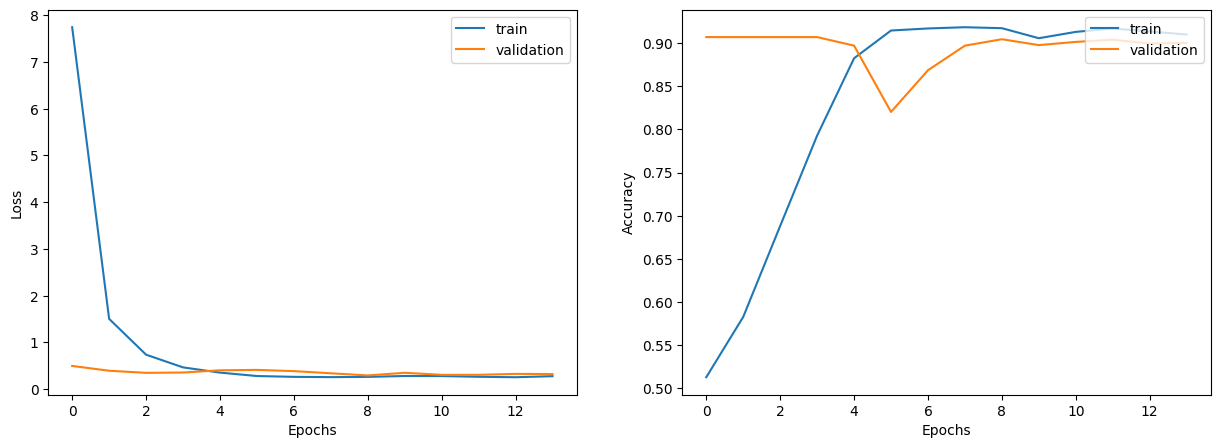

In [173]:
display_learning_curves(history)

In [174]:
from matplotlib import pyplot as plt
import math
# Testing
def test_fun(full_model,x_test,y_test):
    # X_test_new, Y_test_new = final_model(file)
    # print(X_test_new.shape, Y_test_new.shape)
    # Y_test_new = np.array(Y_test_new).astype(None)
    #k_labels = np.array(k_labels).astype(None)
    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = full_model.predict(x=x_test)
        #test_preds = full_model.predict(x = [seq_test_data])
        threshold = t / 100.0
        if(threshold == 1.0):
            threshold = 0.99
        print("THRESHOLD IS =====> ", threshold)
        # print(test_preds.shape)
        
        
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)
        # print(test_preds.shape)
        # print(k_labels.shape)
        rec = recall(y_test, test_preds)

        pre = precision(y_test, test_preds)
        
        recalls.append(rec)
        
        precisions.append(pre)
        # if(pre > 80):
        #   break
        f1 = f_score(y_test, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax
# print("*****************************************GCC EVALUATION******************************************")
# th_set_GCC = test_fun(gnn_model,x_test,y_test)
# print(th_set_GCC)

# th_set_only_LSTM = test_fun(LSTM_model,test_seq_cc,test_label_cc)


# print(th_set_only_LSTM)



In [175]:
es_callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [176]:

def LSTMmodel(features_input,functions):
  n_nodes = features_input.shape[0]
  n_features = features_input.shape[1]
  #batch_size = tf.shape(features_input)[1]
  training=None 
  mask=None
  _input = layers.Input(shape=(1000,))
  batch_size = tf.shape(_input)[0]
  #input = Input(shape=[1,n_nodes])
  #z = tf.squeeze(
   # inputs, axis=0, name=None)
  # z = tf.squeeze(z,axis = 0)
  #print(inputs.shape)
  emb = Embedding(
        input_dim = 8000,
        output_dim = 128,
        input_length= 1000
        )(_input)
    #model.add((LSTM(256,return_sequences=True)))
  # emb = tf.squeeze(
#     emb, axis=0, name=None
# )
  #print(emb.shape)
  conv_1 = keras.layers.Conv1D(
            filters=1024,
            kernel_size=128,
            strides=1,
            padding='valid',
            activation='relu')(emb)

  pool_1 = keras.layers.MaxPool1D(
            pool_size=64,
            strides=32,
            padding='valid')(conv_1)

  dropout_1 = keras.layers.Dropout(0.2)(pool_1)

  temp, state_output = BidLSTM(128)(dropout_1)
  #temp, _ = bidirectional_rnn(dropout_1)# training=training, mask=mask)
  # category_encoding = tf.eye(functions.shape[0])[tf.newaxis, :, :]
  # query = tf.tile(category_encoding, multiples=[batch_size, 1, 1])
  multi_head_attention = MultiHeadAttention(400, 8)
  temp, _ = multi_head_attention(temp, k=temp, v=temp)
  # dropout_2 = keras.layers.Dropout(0.2)(temp,training=training)
  # point_wise_dense_1 = keras.layers.Dense(
  #           units=100,
  #           activation='relu')(dropout_2)

  # point_wise_dense_2 = keras.layers.Dense(
  #           units=1,
  #           activation='sigmoid')(point_wise_dense_1)


  
  # output = tf.reshape(point_wise_dense_2, [-1, functions.shape[0]])
  # # print(output.shape)
  # # dense_1 = tf.keras.layers.Dense(512,activation = 'relu')(state_output)
  # output = tf.keras.layers.Dense(functions.shape[0],activation = 'sigmoid')(output)

  #x = layers.Lambda(lambda xin: K.sum(xin, axis=1))(x)
  # x = layers.Flatten()(temp)
  x = layers.GlobalAveragePooling1D()(temp)
  dropout_2 = keras.layers.Dropout(0.2)(x,training=training)
  output = tf.keras.layers.Dense(functions.shape[0],activation = 'sigmoid')(dropout_2)
  model = tf.keras.Model(inputs=[_input], outputs=[output])
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                  # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025),
                  metrics = tf.keras.metrics.BinaryAccuracy(threshold=0.5))
  return model


In [52]:
node2vec_cc

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.07687346,-0.9226167,0.78992116,-0.84812886,0.49845138,0.38957667,-0.3366734,0.14115053,0,1
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,-0.088856906,-0.49268368,1.0905964,-0.65956247,-0.5185808,-0.29776338,-0.80166334,-0.30129644,1,1
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,-0.6869531,0.84110194,0.27185586,0.67025656,-0.4129803,0.6605675,0.44515988,0.49230257,2,1
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,-0.82656157,-0.0026124702,0.40108162,0.9708959,-0.65667415,-1.4535186,-0.87660235,-0.3967433,3,1
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,-0.3201643,0.39295188,-0.2822794,0.3054697,-0.4024803,-0.9890051,-1.0255593,-0.8270502,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,-0.0010220176,0.0018005054,0.0034822198,0.0030971896,0.0043546455,-0.0037902752,-0.0029614503,0.0018936889,-0.007540119,-0.003903429,...,-0.005177743,-0.0072172927,0.0027994448,0.0013730638,-0.0074134255,3.5839155e-05,-0.0008219704,0.0076927505,2987,1
2988,0.0051305247,-0.00020716991,0.0056356033,-0.001965833,-0.005993656,0.0070756795,-0.0033855522,0.0054469733,0.006430502,-0.00091289077,...,0.0061046714,-0.0038707256,-0.0009500375,0.005390168,0.004127724,0.005776765,-0.0035727564,-0.005217186,2988,2
2989,-0.0021094028,-0.0057895826,-0.0016520573,0.0016188109,0.0019293511,0.0026742155,-0.0032843538,-0.0041193217,-0.0070835156,-0.006367827,...,0.007336351,0.0021708645,0.0049110325,-0.0013499325,0.0031697582,-0.007376888,-0.007607705,0.0018382426,2989,1
2990,-0.0029256037,-0.0078072418,-0.0019403696,0.0041975277,0.006259068,0.0061134314,-0.00096577685,0.0055725453,0.0049415994,-0.0049427627,...,0.0018232781,-0.003252781,0.0038279882,-0.004984987,-0.007729613,0.006608147,0.005017368,-0.00040707085,2990,1


In [177]:
def gcn_model_values(model,data):
    print('Extracting features based on GCN model........')
    pred = model.predict(data)
    return pred

gcn_train_data = gcn_model_values(gnn_model,x_train)
gcn_val_data = gcn_model_values(gnn_model,x_val)
gcn_test_data = gcn_model_values(gnn_model,x_test)
# gcn_test_data  = tf.reduce_sum(gcn_test_data, axis=1)

Extracting features based on GCN model........
66/66 [==============================] - 5s 74ms/step
Extracting features based on GCN model........
17/17 [==============================] - 1s 37ms/step
Extracting features based on GCN model........
12/12 [==============================] - 0s 33ms/step


In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# create a logistic regression model
model = LogisticRegression()

# fit the model to the training data
model.fit(gcn_train_data, y_train)

# make predictions on the training, testing, and validation data
y_train_pred = model.predict(gcn_train_data)
y_test_pred = model.predict(gcn_test_data)
y_val_pred = model.predict(gcn_val_data)

# evaluate the accuracy of the model on the training, testing, and validation data
Lr_test_accuracy = accuracy_score(y_test, y_test_pred)
Lr_val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Testing accuracy: {Lr_test_accuracy}")
print(f"Validation accuracy: {Lr_val_accuracy}")


Testing accuracy: 0.8833333333333333
Validation accuracy: 0.8605947955390335


In [179]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# initialize the decision tree classifier with the appropriate hyperparameters
max_depth = 10
min_samples_split = 5
model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

# train the decision tree classifier on your training data
model.fit(gcn_train_data, y_train)

# evaluate the performance of the decision tree classifier on your validation data
y_pred_val = model.predict(gcn_val_data)
Dt_val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy: {:.2f}%".format(Dt_val_accuracy * 100))

# evaluate the performance of the decision tree classifier on your testing data
y_pred_test = model.predict(gcn_test_data)
Dt_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Dt_test_accuracy * 100))


Validation accuracy: 84.01%
Testing accuracy: 82.78%


In [196]:
X_train = gcn_train_data
X_val = gcn_val_data
X_test = gcn_test_data

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# initialize the random forest classifier with the appropriate hyperparameters
n_estimators = 100
max_depth = 10
min_samples_split = 5
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

# train the random forest classifier on your training data
model.fit(gcn_train_data, y_train)

# evaluate the performance of the random forest classifier on your validation data
y_pred_val = model.predict(gcn_val_data)
Rf_val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy: {:.2f}%".format(Rf_val_accuracy * 100))

# evaluate the performance of the random forest classifier on your testing data
y_pred_test = model.predict(gcn_test_data)
Rf_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Rf_test_accuracy * 100))


ValueError: ignored

In [194]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# initialize the SVM classifier with the appropriate hyperparameters
C = 1.0
kernel = 'rbf'
gamma = 'scale'
model = SVC(C=C, kernel=kernel, gamma=gamma)

# train the SVM classifier on your training data
model.fit(X_train, y_train)

# evaluate the performance of the SVM classifier on your validation data
y_pred_val = model.predict(X_val)
Svm_val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy: {:.2f}%".format(Svm_val_accuracy * 100))

# evaluate the performance of the SVM classifier on your testing data
y_pred_test = model.predict(X_test)
Svm_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Svm_test_accuracy * 100))


Validation accuracy: 53.16%
Testing accuracy: 55.28%


In [195]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# initialize the AdaBoost classifier with the appropriate hyperparameters
n_estimators = 100
learning_rate = 1.0
algorithm = 'SAMME.R'
model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm)

# train the AdaBoost classifier on your training data
model.fit(X_train, y_train)

# evaluate the performance of the AdaBoost classifier on your validation data
y_pred_val = model.predict(X_val)
Ada_val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy: {:.2f}%".format(Ada_val_accuracy * 100))

# evaluate the performance of the AdaBoost classifier on your testing data
y_pred_test = model.predict(X_test)
Ada_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Ada_test_accuracy * 100))


Validation accuracy: 39.96%
Testing accuracy: 42.22%


In [184]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 


# initialize the Extra Trees classifier with the appropriate hyperparameters
n_estimators = 100
max_depth = None
min_samples_split = 2
random_state = 42
model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                             min_samples_split=min_samples_split, random_state=random_state)

# train the Extra Trees classifier on your training data
model.fit(X_train, y_train)

# evaluate the performance of the Extra Trees classifier on your validation data
y_pred_val = model.predict(X_val)
Et_val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy: {:.2f}%".format(Et_val_accuracy * 100))

# evaluate the performance of the Extra Trees classifier on your testing data
y_pred_test = model.predict(X_test)
Et_test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing accuracy: {:.2f}%".format(Et_test_accuracy * 100))


Validation accuracy: 85.50%
Testing accuracy: 87.50%


In [185]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# initialize the SGD classifier with the appropriate hyperparameters
alpha = 0.0001
max_iter = 1000
tol = 1e-3
model = SGDClassifier(alpha=alpha, max_iter=max_iter, tol=tol)

# train the SGD classifier on your training data
model.fit(X_train, y_train)

# evaluate the performance of the SGD classifier on your validation data
y_pred_val = model.predict(X_val)
Sgd_val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy: {:.2f}%".format(Sgd_val_accuracy * 100))

# evaluate the performance of the SGD classifier on your testing data
y_pred_test = model.predict(X_test)
Sgd_test_accuracy = accuracy_score(y_test, y_pred_test)
Sgd_test_recall = recall_score(y_test, y_pred_test, average = 'macro')
Sgd_test_f1_score = f1_score(y_test, y_pred_test, average = 'macro')
print("Testing accuracy: {:.2f}%".format(Sgd_test_accuracy * 100))


Validation accuracy: 85.69%
Testing accuracy: 88.89%


In [186]:
Accuracies = [Dt_test_accuracy * 100, Ada_test_accuracy * 100, Lr_test_accuracy * 100, Sgd_test_accuracy * 100, Rf_test_accuracy * 100, Et_test_accuracy * 100, Svm_test_accuracy * 100]
models = ["DT","AdaBoost", "LR", "SGD",  "RF",  "ETC","SVM"]

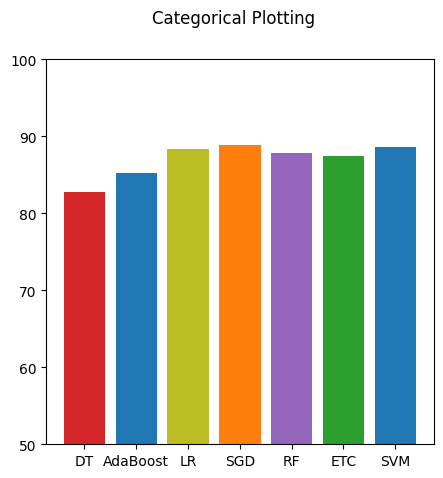

In [188]:
import matplotlib.pyplot as plt
bar_labels = ['red', 'blue', 'olive', 'orange', 'purple', 'green', 'blue']
bar_colors = ['tab:red', 'tab:blue', 'tab:olive', 'tab:orange', 'tab:purple', 'tab:green', 'tab:blue']

names = models
values = Accuracies

fig, axs = plt.subplots()
axs.bar(names, values,label=bar_labels, color=bar_colors)
plt.ylim(bottom=50, top=100)
plt.rcParams["figure.figsize"] = (5,5)
fig.suptitle('Categorical Plotting')
fig.set_size_inches(5, 5)  # width, height in inches

# Show the plot

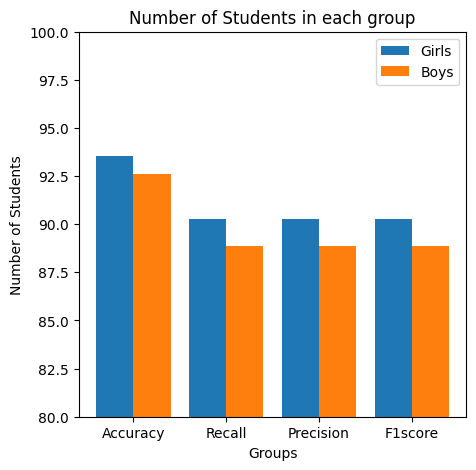

In [190]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Accuracy','Recall','Precision','F1score']
Ygirls = [93.52,90.27,90.27,90.28]
Zboys = [92.59,88.88,88.88,88.89]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Girls')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
plt.ylim(bottom=80, top=100)
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()